# Intro

This notebook implements an experiment aimed to verify accuracy of Deep Hybrid AutoencodeR Recommendation ENgine (DHARREN), on a dataset used in a [recent publication](https://github.com/MengtingWan/marketBias). 

# Technical prep

In [1]:
import pandas as pd
import os
import sys
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


from tqdm.autonotebook import tqdm
from tqdm import trange

C:\Users\fwojcik\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  del sys.path[0]


In [2]:
%matplotlib inline

In [3]:
%load_ext autoreload

%autoreload 2

In [4]:
if os.getcwd().endswith("notebooks"):
    os.chdir(os.pardir)

In [5]:
sys.path.append(os.getcwd())

In [6]:
from src.data.train_data_utils import prepare_experiment_data
from src.models.training_utils import generator_ratings, generator_ratings_features, mae_masked, mape_masked, mse_masked
from src.models.train_model import get_collabfiltering_model1, build_shallow_autorec_single_input, build_autorec_multi_input2

# Data prep

In [7]:
exd = prepare_experiment_data()

Processed: 0.0%
Processed: 0.27373261797875836%
Processed: 0.5474652359575167%
Processed: 0.8211978539362751%
Processed: 0.0%
Processed: 0.4555393586005831%
Processed: 0.9110787172011662%
Processed: 0.0%
Processed: 0.6804109682248077%


# Modeling phase

## Experimental setup

## Collaborative filtering

Deep collaborative filtering implementation can be inspired by the following tutorial:

https://medium.com/@jdwittenauer/deep-learning-with-keras-recommender-systems-e7b99cb29929


Other working implementation:

https://www.smartlab.at/articles/implement-a-book-recommendation-system-with-tensorflow/

Implementation in Keras:

https://www.onceupondata.com/2019/02/10/nn-collaborative-filtering/

Other implementation using embeddings

https://github.com/CVxTz/Recommender_keras

In [12]:
X_colab_all = np.vstack((exd.Xratings_train.todense(), exd.Xratings_valid.todense()))

In [13]:
X_colab_all.shape

(40670, 6556)

In [14]:
nusers = X_colab_all.shape[0]
nitems = X_colab_all.shape[1]
factors = 128

### Keras impl

In [8]:
def get_array(series):
    return np.array([[element] for element in series])

In [9]:
max_uid = max(
    set(exd.Xraw_train.user_id.unique()).union(
        set(exd.Xraw_test.user_id.unique())
    ).union(
        set(exd.Xraw_valid.user_id.unique())
    ))
max_iid = exd.Xratings_train.shape[1]

In [10]:
colab_keras = get_collabfiltering_model1(max_uid + 1, max_iid + 1)

In [22]:
uid_train_array = get_array(exd.Xraw_train.user_id)
iid_train_array = get_array(exd.Xraw_train.item_id)
rating_train_array = get_array(exd.Xraw_train.rating)

uid_val_array = get_array(exd.Xraw_valid.user_id)
iid_val_array = get_array(exd.Xraw_valid.item_id)
rating_val_array = get_array(exd.Xraw_valid.rating)

uid_test_array = get_array(exd.test_uids_original) #(exd.Xraw_test.user_id)
iid_test_array = get_array(exd.test_iids) #(exd.Xraw_test.item_id)

In [12]:
colab_keras.fit(
    [iid_train_array, uid_train_array], 
    rating_train_array,
    epochs=10,
    validation_data=([iid_val_array, uid_val_array], rating_val_array),
    verbose=1)

Train on 36532 samples, validate on 14697 samples
Epoch 1/10
36532/36532 [==============================] - 19s 517us/sample - loss: 15.0108 - mse_masked: 15.0093 - mape_masked: 0.8430 - mae_masked: 3.6741 - val_loss: 11.3930 - val_mse_masked: 11.3866 - val_mape_masked: 0.6947 - val_mae_masked: 3.1708
Epoch 2/10
36532/36532 [==============================] - 14s 380us/sample - loss: 8.5211 - mse_masked: 8.5206 - mape_masked: 0.5493 - mae_masked: 2.7221 - val_loss: 6.3423 - val_mse_masked: 6.3386 - val_mape_masked: 0.4282 - val_mae_masked: 2.3442
Epoch 3/10
36532/36532 [==============================] - 15s 402us/sample - loss: 4.0685 - mse_masked: 4.0680 - mape_masked: 0.2653 - mae_masked: 1.8592 - val_loss: 3.5564 - val_mse_masked: 3.5549 - val_mape_masked: 0.2137 - val_mae_masked: 1.7624
Epoch 4/10
36532/36532 [==============================] - 14s 390us/sample - loss: 1.6703 - mse_masked: 1.6701 - mape_masked: 0.0243 - mae_masked: 1.1479 - val_loss: 2.4104 - val_mse_masked: 2.4101 -

In [23]:
yhat = colab_keras.predict([iid_test_array, uid_test_array])

In [24]:
mape_masked(y_true=exd.test_y, y_pred=yhat.flatten())

<tf.Tensor: shape=(), dtype=float32, numpy=-0.037578776>

In [25]:
mse_masked(exd.test_y, yhat.flatten()).numpy(), mape_masked(exd.test_y, yhat.flatten()).numpy(), mae_masked(exd.test_y, yhat.flatten()).numpy()

(1.8952059, -0.037578776, 1.2496824)

## Autoencoders

### Train shallow

In [8]:
batch_size = 64
steps_per_epoch = exd.Xratings_train.shape[0] // batch_size

shallow_autorec = build_shallow_autorec_single_input(exd.Xratings_train.shape[1])
results_autorec_simple = shallow_autorec.fit_generator(
    generator_ratings(exd.Xratings_train, batch_size), 
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_data=(exd.Xratings_valid.toarray().astype(np.float32), exd.Xratings_valid.toarray().astype(np.float32))
    )

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6556)]            0         
_________________________________________________________________
dropout (Dropout)            (None, 6556)              0         
_________________________________________________________________
dense (Dense)                (None, 819)               5370183   
_________________________________________________________________
dropout_1 (Dropout)          (None, 819)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6556)              5375920   
Total params: 10,746,103
Trainable params: 10,746,103
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
shuffling the data
 39/317 [==>...........................] - ETA: 1:43 - loss: 18.7560 - mse_maske

KeyboardInterrupt: 

In [9]:
Xr_test_reconstruction_shallow = shallow_autorec.predict(exd.Xratings_test.toarray())

In [10]:
mse_masked(exd.Xratings_test.toarray(), Xr_test_reconstruction_shallow)

<tf.Tensor: id=15466, shape=(), dtype=float32, numpy=15.610277>

In [11]:
yhat = []
for test_uid, test_itemid in zip(exd.test_uids, exd.test_iids):
    yhat.append(Xr_test_reconstruction_shallow[test_uid, test_itemid])

In [12]:
mse_masked(exd.test_y, yhat).numpy(), mape_masked(exd.test_y, yhat).numpy(), mae_masked(exd.test_y, yhat).numpy()

(16.486862, 0.91637343, 3.8561344)

### Train multi input

In [15]:

batch_size = 64
steps_per_epoch = exd.Xratings_train.shape[0] // batch_size

Xratings_valid_arr = exd.Xratings_valid.toarray().astype(np.float32)

deep_autorec_multi = build_autorec_multi_input2(exd.Xratings_train.shape[1], exd.Xfeatures_train.shape[1])
results_autorec_multi = deep_autorec_multi.fit_generator(
    generator_ratings_features(exd.Xratings_train, exd.Xfeatures_train, batch_size), 
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_data=([
        Xratings_valid_arr, 
        exd.Xfeatures_valid], Xratings_valid_arr)
)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 6556)]       0                                            
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 6556)         0           input_2[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1639)         10746923    dropout_2[0][0]                  
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 61)]         0                                            
____________________________________________________________________________________________

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [187]:
Xr_test_reconstruction_multi = deep_autorec_multi.predict([Xr_test_pred_hidden.toarray(), Xf_test])
mse_masked(Xr_test_pred_hidden.toarray(), Xr_test_reconstruction_multi).numpy()

2.9584022

In [188]:
yhat_multi = []
for test_uid, test_itemid in zip(test_uids, test_item_ids):
    yhat_multi.append(Xr_test_reconstruction_multi[test_uid, test_itemid])
    
mse_masked(test_y, yhat_multi).numpy(), mape_masked(test_y, yhat_multi).numpy(), mae_masked(test_y, yhat_multi).numpy()

(3.5427463, 0.012227664, 1.4799496)

In [189]:
pd.DataFrame({'y': test_y, 'yhat': yhat_multi})

,y,yhat
0,4,3.707496
1,5,3.352658
2,4,3.824492
3,5,3.861844
4,2,5.124014
...,...,...
119,5,4.234419
120,4,3.796869
121,5,1.594608
122,3,2.677118


In [190]:
from sklearn.metrics import r2_score

r2_score(test_y, yhat_multi)

-1.0414206115887032

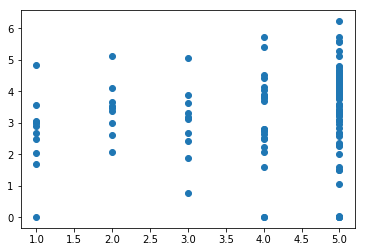

In [191]:
plt.scatter(test_y, yhat_multi)

# Memory cleanup

In [13]:
import gc
tf.keras.backend.clear_session()
gc.collect()

7255